In [1]:
import os
import numpy as np 
from tqdm.auto import trange

In [2]:
import spender

In [3]:
import torch

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
dat_dir = '/scratch/network/chhahn/sedflow/training_sed/'
wave = np.load('/scratch/network/chhahn/sedflow/sdss.clean.wave.npy')
spec = np.load(os.path.join(dat_dir, 'train.v0.1.1.seds.nde_noise.npy')).astype(np.float32)
ivar = np.load(os.path.join(dat_dir, 'train.v0.1.1.ivar.nde_noise.npy')).astype(np.float32)
zred = np.load(os.path.join(dat_dir, 'train.v0.1.1.redshifts.npy'))

(3784.426513671875, 9270.4306640625)

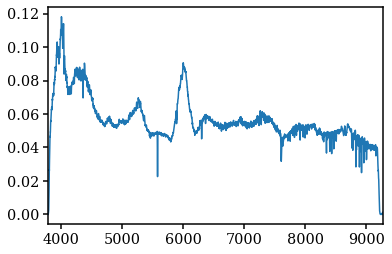

In [6]:
plt.plot(wave, ivar[4])
plt.xlim(wave[0], wave[-1])

## prepare spectrum
mimicing https://github.com/pmelchior/spender/blob/main/spender/data/sdss.py#L242

In [7]:
norm = np.empty(spec.shape[0])
for i in range(spec.shape[0]): 
    wave_rest = wave / (1 + zred[i])
    
    sel = (wave_rest > 5300.) & (wave_rest < 5850.)
    norm[i] = np.median(spec[i][sel])

### load best-fit model

In [8]:
from spender.data.sdss import SDSS

In [9]:
sdss = SDSS()

In [10]:
auto, loss = spender.load_model('/scratch/network/chhahn/sedflow/sdss.speculator+1.variable.lr_1e-3.latent_10.0.pt', 
                          instrument=sdss, device='cpu')

In [11]:
_spec = torch.zeros((spec.shape[0], len(sdss.wave_obs)))

start = int(np.around((np.log10(wave)[0] - torch.log10(sdss.wave_obs[0]).item())/0.0001))
end = min(start+len(np.log10(wave)), len(sdss.wave_obs))

_spec[:,start:end]= torch.from_numpy(spec/norm[:,None])

In [12]:
s_spec = []
for ichunk in trange(100): 
    with torch.no_grad(): 
        _s = auto.encode(_spec[ichunk*1000:(ichunk+1)*1000], 
                        aux=torch.tensor(zred[ichunk*1000:(ichunk+1)*1000].astype(np.float32)).unsqueeze(1))
        
        s_spec.append(_s)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
s_spec = np.concatenate([s.detach().numpy() for s in s_spec])

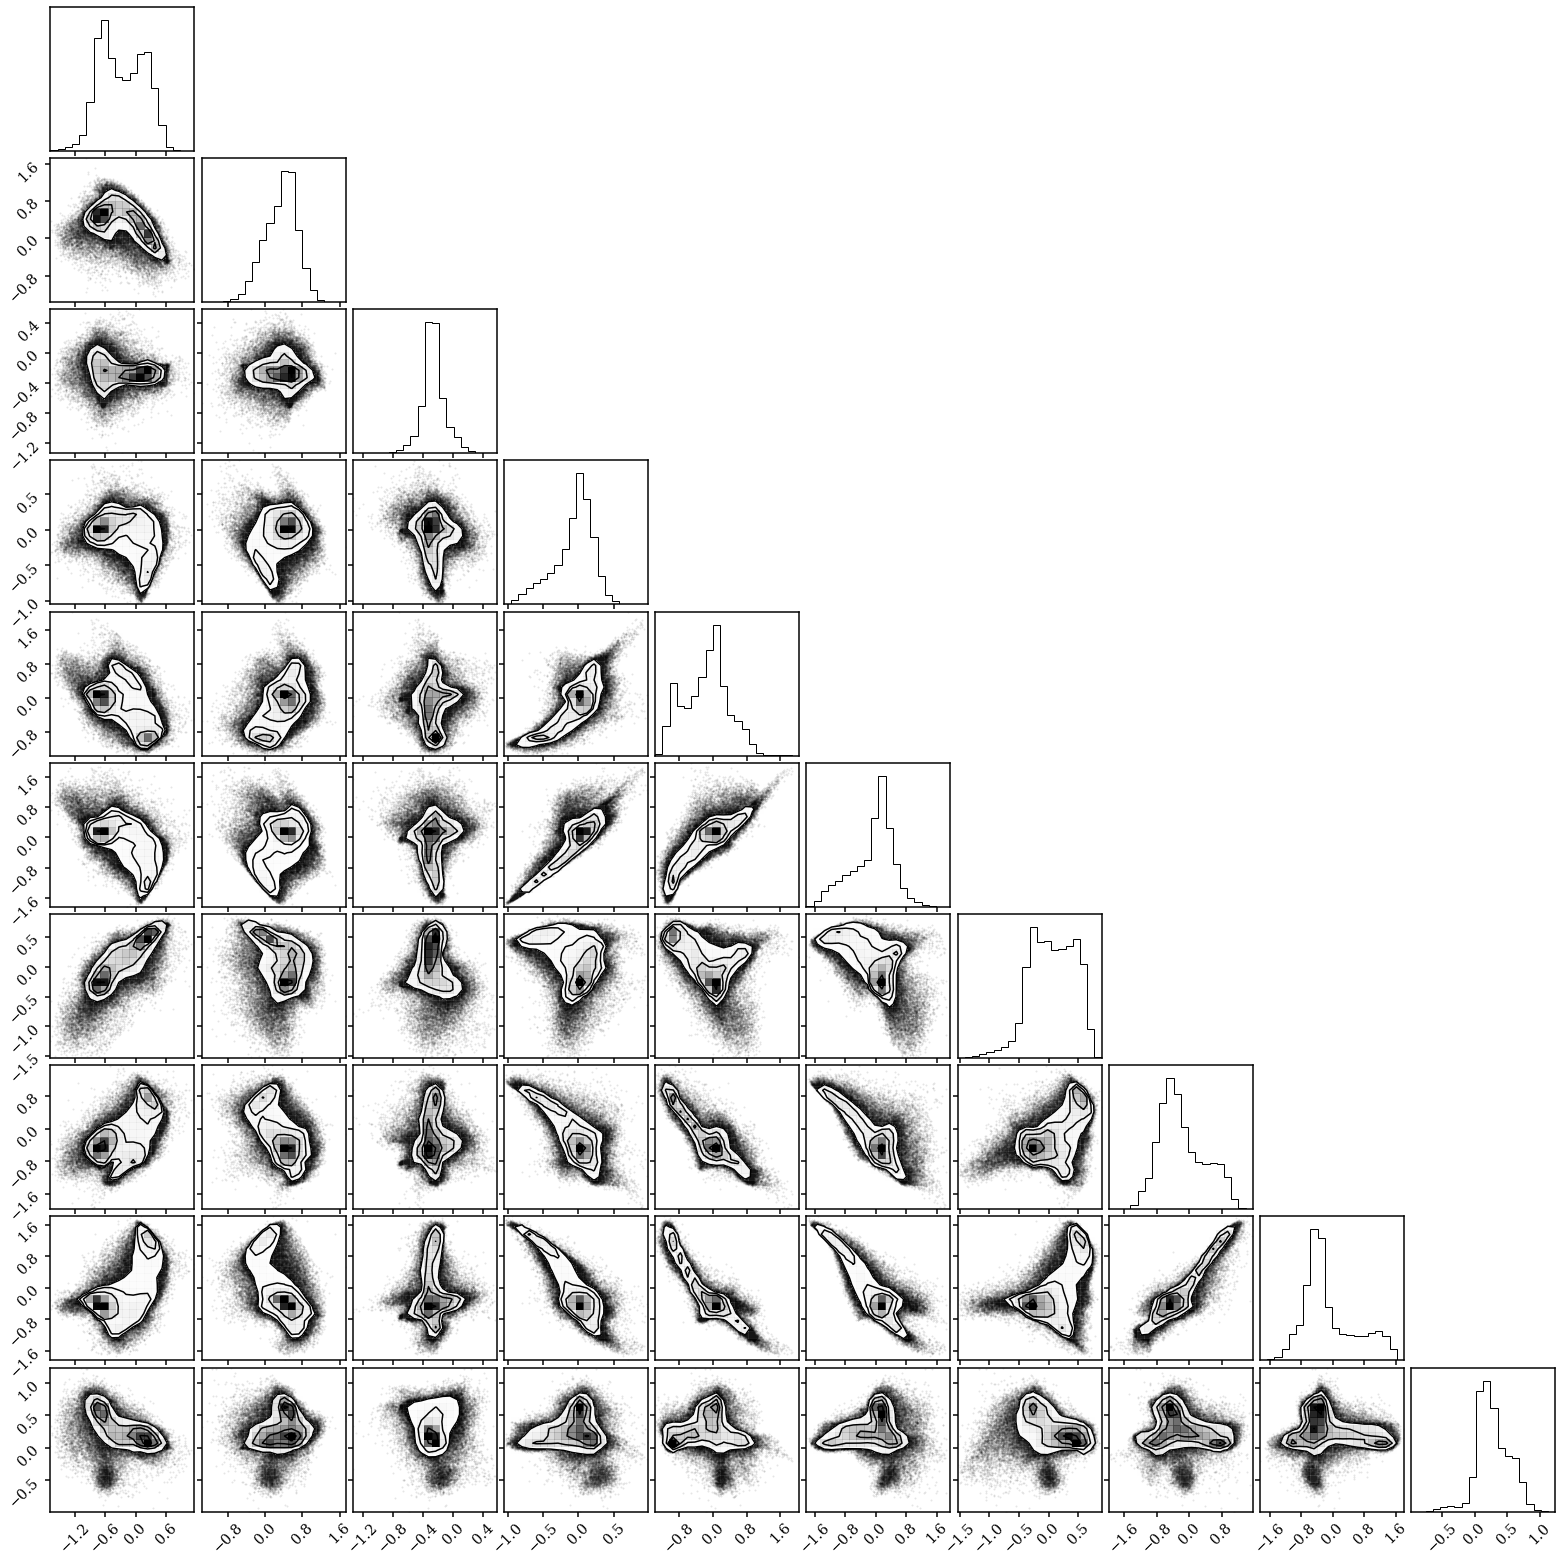

In [21]:
fig = DFM.corner(np.array(s_spec))

In [22]:
np.save(os.path.join(dat_dir, 'train.v0.1.1.h_spec.nde_noise.spender.npy'), s_spec)